In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from torchvision import models

In [2]:
class NPZDataset(Dataset):
    def __init__(self, path, indices=None, resize=256, device="cpu"):
        self.data = np.load(path, allow_pickle=True, mmap_mode="r")
        self.images = self.data["images"]
        self.labels = self.data["labels"]

        if indices is None:
            self.indices = np.arange(len(self.labels))
        else:
            self.indices = indices

        self.resize = resize
        self.device = device

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        img = torch.tensor(self.images[i]).float()
        lbl = torch.tensor(self.labels[i]).float()

        img = img.permute(2,0,1)
        if img.max() > 1:
            img = img / 255.

        img = F.interpolate(
            img.unsqueeze(0),
            size=(self.resize, self.resize),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        return img.to(self.device), lbl.to(self.device)

class SyntheticDataset(Dataset):
    def __init__(self, path, device):
        d = np.load(path)
        self.images = d["images"]
        self.labels = d["labels"]
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx], dtype=torch.float32).permute(2,0,1)
        lbl = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img.to(self.device), lbl.to(self.device)

In [3]:
def load_train_test(path, device="cpu", batch_size=32, resize=256, test_size=0.6):
    dataset_full = NPZDataset(path, device=device, resize=resize)
    indices = np.arange(len(dataset_full.labels))

    # Nếu test_size = 0 → không split
    if test_size == 0:
        train_idx = indices
        test_idx = []
    else:
        train_idx, test_idx = train_test_split(
            indices,
            test_size=test_size,
            stratify=dataset_full.labels,
            random_state=42
        )

    train_dataset = NPZDataset(path, indices=train_idx, device=device, resize=resize)
    test_dataset  = NPZDataset(path, indices=test_idx,  device=device, resize=resize) if len(test_idx) > 0 else None

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size) if test_dataset is not None else None

    return train_dataset, train_loader, test_dataset, test_loader

def count_classes(dataset):
    count0 = 0
    count1 = 0
    
    for i in range(len(dataset)):
        lbl = dataset[i][1]    # dataset[i] → (image, label)
        lbl = int(lbl.item())  # convert to 0 hoặc 1
        
        if lbl == 0:
            count0 += 1
        else:
            count1 += 1
    return count0, count1

def evaluate_model(model, loader, device, threshold=0.5):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch).squeeze()
            all_preds.append(y_pred.cpu())
            all_labels.append(y_batch.cpu())

    preds = torch.cat(all_preds).numpy()
    labels = torch.cat(all_labels).numpy()


    binary_pred = (preds > threshold).astype(int)
    
    print("Classification Report:")
    print(classification_report(labels, binary_pred, labels=[0,1], target_names=["Class 0","Class 1"]))

    if len(set(labels)) > 1:
        auc = roc_auc_score(labels, preds)
        print(f"AUC-ROC: {auc:.4f}")
    else:
        print("AUC-ROC: Undefined (only one class present)")

In [4]:
class ResNetEmbedder(nn.Module):
    def __init__(self, output_dim=128, pretrained=True):
        super().__init__()
        self.backbone = models.resnet50(pretrained=pretrained)
        self.backbone.fc = nn.Identity()
        self.dim_adjuster = nn.Linear(2048, output_dim)
        self.output_dim = output_dim

    def forward(self, images):
        features = self.backbone(images)
        features = features.squeeze()
        if features.dim() == 1:
            features = features.unsqueeze(0)
        features = self.dim_adjuster(features)
        return features

class CNNAutoEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,64,4,2,1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128,256,4,2,1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256,512,4,2,1), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.encoder2latent = nn.Linear(512*16*16+1, latent_dim)
        self.latent2decoder = nn.Linear(latent_dim+1, 512*16*16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,2,1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64,3,4,2,1), nn.Sigmoid()
        )

    def encode(self, x, y):
        h = self.encoder(x)
        flat = h.view(x.size(0), -1)
        xy = torch.cat([flat, y], dim=1)
        z = self.encoder2latent(xy)
        return z

    def decode(self, z, y):
        zy = torch.cat([z, y], dim=1)
        flat = self.latent2decoder(zy)
        h = flat.view(z.size(0),512,16,16)
        x_recon = self.decoder(h)
        return x_recon

    def forward(self, x, y):
        z = self.encode(x, y)
        return self.decode(z, y)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0,max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0,d_model,2).float()*(-np.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position*div_term)
        pe[:,1::2] = torch.cos(position*div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self,x):
        L = x.size(1)
        return x + self.pe[:,:L,:]

class ViTransformerDetector(nn.Module):
    def __init__(self, embedder, d_model=128, nhead=8, num_layers=2, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.embedder = embedder
        self.embedding_dim = embedder.output_dim
        self.projection = nn.Linear(self.embedding_dim,d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(d_model,128), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(128,1), nn.Sigmoid()
        )

    def forward(self,x):
        emb = self.embedder(x).view(x.size(0),1,-1)
        emb = self.projection(emb)
        emb = self.positional_encoding(emb)
        h = self.transformer_encoder(emb)
        pooled = h.mean(dim=1)
        return self.fc(pooled).squeeze(1)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def step(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

In [5]:
def train_cnn_ae(model, loader, opt, device):
    model.train()
    total = 0
    for x,y in loader:
        x = x.to(device)
        y = y.unsqueeze(1).to(device)
        recon = model.decode(model.encode(x,y), y)
        loss = F.mse_loss(recon, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item()
    return total/len(loader)


def train_detector(model, loader, opt, criterion, device):
    model.train()
    total = 0
    for x,y in loader:
        x=x.to(device); y=y.to(device)
        out = model(x)
        loss = criterion(out, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item()
    return total/len(loader)

In [6]:
def One_Step_To_Feasible_Action(generator, detector, x_orig, device,
                                previously_generated=None, alpha=1.0,
                                lambda_div=0.1, lr=0.001, steps=50):
    generator.eval()
    detector.eval()
    if previously_generated is None:
        previously_generated = []

    x_orig = x_orig.to(device).unsqueeze(0)
    y_class1 = torch.full((1,1),0.8,device=device)

    with torch.no_grad():
        z = generator.encode(x_orig, y_class1)
    z = z.clone().detach().requires_grad_(True)

    optimizer_z = torch.optim.Adam([z], lr=lr)

    for step in range(steps):
        optimizer_z.zero_grad()
        x_syn = generator.decode(z, y_class1)
        prob_class1 = detector(x_syn)

        if len(previously_generated) > 0:
            old = torch.stack(previously_generated).to(device)
            diff = x_syn.unsqueeze(1)-old.unsqueeze(0)
            dist_min = diff.norm(p=2,dim=(2,3,4)).min(dim=1).values
            diversity_term = torch.exp(-alpha*dist_min).mean()
        else:
            diversity_term = torch.tensor(0.0, device=device)

        reward = prob_class1.mean() + lambda_div*diversity_term
        reward.backward()
        optimizer_z.step()

    with torch.no_grad():
        x_adv = generator.decode(z, y_class1).detach().cpu()

    return x_adv

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_DIR = "/kaggle/input/bmad-80-20-npz/bmad-npz"
DATASET_NAME = "camelyon16_256"
# DATASET_NAME = "BraTS2021_slice"
# DATASET_NAME = "hist_DIY"
DATASET_PATH = f"{DATASET_DIR}/{DATASET_NAME}/{DATASET_NAME}_train.npz"
SYNTHETIC_DIR = f"synthetics/"
os.makedirs(SYNTHETIC_DIR, exist_ok=True)
MODEL_DIR = f"{DATASET_NAME}_models/"
os.makedirs(MODEL_DIR, exist_ok=True)
PATIENTCE = 5
BATCH_SIZE = 100

train_dataset, train_loader, test_dataset, test_loader = load_train_test(
    DATASET_PATH, device=DEVICE, batch_size=BATCH_SIZE, resize=256
)

generator = CNNAutoEncoder(latent_dim=64).to(DEVICE)
embedder = ResNetEmbedder(output_dim=128).to(DEVICE)
detector = ViTransformerDetector(embedder=embedder).to(DEVICE)
early_stopper = EarlyStopping(patience=PATIENTCE)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(detector.parameters(), lr=1e-4)
criterion = nn.BCELoss()

synthetic_files = []
num_epochs_generator = 100
num_epochs_detector = 100
num_episodes = 100
num_gen_data = 50
combined_dataset = train_dataset

for ep in range(num_episodes):
    print(f"\n================ EPISODE {ep+1}/{num_episodes} ================")
    total_class0, total_class1 = count_classes(combined_dataset)
    
    # 2️⃣ Print
    print(f"[Episode {ep+1}] Class count → 0: {total_class0}, 1: {total_class1}")
    
    # 3️⃣ Auto-stop if balanced
    if total_class1 >= total_class0:
        print("Dataset is now balanced. Stopping synthetic generation.")
        break

    # TRAIN GENERATOR
    early_stopper.reset()
    for epoch in range(num_epochs_generator):
        loss_g = train_cnn_ae(generator, train_loader, optimizer_g, DEVICE)
        print(f"[GENERATOR] Epoch {epoch+1}/{num_epochs_generator}, Loss={loss_g:.4f}")
        early_stopper.step(loss_g)
        if early_stopper.early_stop:
            print(f"[GENERATOR] Early stopping at epoch {epoch+1}")
            break

    torch.save(generator.state_dict(), f"{MODEL_DIR}/{DATASET_NAME}_generator.pth")

    # 4️⃣ Train detector
    early_stopper.reset()
    for epoch in range(num_epochs_detector):
        loss_d = train_detector(detector, train_loader, optimizer_d, criterion, DEVICE)
        print(f"[DETECTOR] Epoch {epoch+1}/{num_epochs_detector}, Loss={loss_d:.4f}")
        early_stopper.step(loss_d)
        if early_stopper.early_stop:
            print(f"[DETECTOR] Early stopping at epoch {epoch+1}")
            break

    torch.save(detector.state_dict(), f"{MODEL_DIR}/{DATASET_NAME}_detector.pth")

    # 5️⃣ Generate synthetic samples (class 1)
    synthetic_samples = []
    idx_class1 = [i for i, idx_lbl in enumerate(train_dataset.indices) if train_dataset.labels[idx_lbl] == 1]

    for _ in range(num_gen_data):
        if not idx_class1:
            break
        rand_idx = np.random.choice(idx_class1)
        x_orig, _ = train_dataset[rand_idx]
        x_adv = One_Step_To_Feasible_Action(generator, detector, x_orig, DEVICE)
        synthetic_samples.append(x_adv.to(DEVICE))

    syn_tensor = torch.cat(synthetic_samples)            # (N,3,H,W)
    syn_tensor_hwc = syn_tensor.permute(0,2,3,1).cpu().numpy()   # (N,H,W,3)  <-- HWC
    syn_labels = np.ones(len(synthetic_samples), dtype=np.float32)
    
    syn_path = f"{SYNTHETIC_DIR}/syn_ep{ep}.npz"
    np.savez_compressed(syn_path, images=syn_tensor_hwc, labels=syn_labels)
    synthetic_files.append(syn_path)

    print(f"[EP {ep}] Generated synthetic saved:", syn_path)

    synthetic_subsets = []
    for f in synthetic_files:
        synthetic_subsets.append(SyntheticDataset(f, DEVICE))
    
    synthetic_full = ConcatDataset(synthetic_subsets)
    combined_dataset = ConcatDataset([train_dataset, synthetic_full])
    
    train_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)
    print(f"[EP {ep}] Train dataset expanded: now {len(combined_dataset)} samples")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]



================ EPISODE 1/100 ================
[Episode 1] Class count → 0: 1986, 1: 356
[GENERATOR] Epoch 1/100, Loss=0.0745
[GENERATOR] Epoch 2/100, Loss=0.0558
[GENERATOR] Epoch 3/100, Loss=0.0497
[GENERATOR] Epoch 4/100, Loss=0.0462
[GENERATOR] Epoch 5/100, Loss=0.0431
[GENERATOR] Epoch 6/100, Loss=0.0403
[GENERATOR] Epoch 7/100, Loss=0.0381
[GENERATOR] Epoch 8/100, Loss=0.0368
[GENERATOR] Epoch 9/100, Loss=0.0358
[GENERATOR] Epoch 10/100, Loss=0.0350
[GENERATOR] Epoch 11/100, Loss=0.0343
[GENERATOR] Epoch 12/100, Loss=0.0334
[GENERATOR] Epoch 13/100, Loss=0.0331
[GENERATOR] Epoch 14/100, Loss=0.0326
[GENERATOR] Epoch 15/100, Loss=0.0322
[GENERATOR] Epoch 16/100, Loss=0.0320
[GENERATOR] Epoch 17/100, Loss=0.0317
[GENERATOR] Epoch 18/100, Loss=0.0314
[GENERATOR] Epoch 19/100, Loss=0.0314
[GENERATOR] Epoch 20/100, Loss=0.0313
[GENERATOR] Epoch 21/100, Loss=0.0312
[GENERATOR] Epoch 22/100, Loss=0.0311
[GENERATOR] Epoch 23/100, Loss=0.0310
[GENERATOR] Epoch 24/100, Loss=0.0308
[GENER

In [8]:
final_detector = ViTransformerDetector(embedder=embedder).to(DEVICE)
optimizer_final = torch.optim.Adam(final_detector.parameters(), lr=1e-3)
criterion = nn.BCELoss()
num_epochs_final = 100
early_stopper.reset()

for epoch in range(num_epochs_final):
    loss = train_detector(final_detector, train_loader, optimizer_final, criterion, DEVICE)
    print(f"[FINAL DETECTOR] Epoch {epoch+1}/{num_epochs_final}, Loss={loss:.4f}")

    # Check early stopping
    early_stopper.step(loss)
    
    if early_stopper.early_stop:
        print(f"[FINAL DETECTOR] Early stopping at epoch {epoch+1}")
        break

[FINAL DETECTOR] Epoch 1/100, Loss=0.2578
[FINAL DETECTOR] Epoch 2/100, Loss=0.1582
[FINAL DETECTOR] Epoch 3/100, Loss=0.1005
[FINAL DETECTOR] Epoch 4/100, Loss=0.0956
[FINAL DETECTOR] Epoch 5/100, Loss=0.0838
[FINAL DETECTOR] Epoch 6/100, Loss=0.0896
[FINAL DETECTOR] Epoch 7/100, Loss=0.0713
[FINAL DETECTOR] Epoch 8/100, Loss=0.0565
[FINAL DETECTOR] Epoch 9/100, Loss=0.0535
[FINAL DETECTOR] Epoch 10/100, Loss=0.0455
[FINAL DETECTOR] Epoch 11/100, Loss=0.0295
[FINAL DETECTOR] Epoch 12/100, Loss=0.0296
[FINAL DETECTOR] Epoch 13/100, Loss=0.0285
[FINAL DETECTOR] Epoch 14/100, Loss=0.0389
[FINAL DETECTOR] Epoch 15/100, Loss=0.0585
[FINAL DETECTOR] Epoch 16/100, Loss=0.0547
[FINAL DETECTOR] Epoch 17/100, Loss=0.0598
[FINAL DETECTOR] Epoch 18/100, Loss=0.0251
[FINAL DETECTOR] Epoch 19/100, Loss=0.0376
[FINAL DETECTOR] Epoch 20/100, Loss=0.0423
[FINAL DETECTOR] Epoch 21/100, Loss=0.0322
[FINAL DETECTOR] Epoch 22/100, Loss=0.0216
[FINAL DETECTOR] Epoch 23/100, Loss=0.0168
[FINAL DETECTOR] Epo

In [9]:
evaluate_model(final_detector, test_loader, DEVICE, threshold=0.3)

# Save final detector
torch.save(final_detector.state_dict(), f"{MODEL_DIR}/{DATASET_NAME}_detector_final.pth")
print(f"Final detector saved to {MODEL_DIR}/{DATASET_NAME}_detector_final.pth")

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.97      0.97      2980
     Class 1       0.83      0.78      0.81       534

    accuracy                           0.94      3514
   macro avg       0.90      0.88      0.89      3514
weighted avg       0.94      0.94      0.94      3514

AUC-ROC: 0.9551
Final detector saved to camelyon16_256_models//camelyon16_256_detector_final.pth


In [10]:
import shutil

synthetics_folder = "/kaggle/working/synthetics"
synthetics_zip = f"{DATASET_NAME}_synthetics"

shutil.make_archive(synthetics_zip, 'zip', synthetics_folder)

'/kaggle/working/camelyon16_256_synthetics.zip'

In [18]:
import shutil

models_folder = f"/kaggle/working/{DATASET_NAME}_models"
models_zip = f"{DATASET_NAME}_models"

shutil.make_archive(models_zip, 'zip', models_folder)

'/kaggle/working/camelyon16_256_models.zip'

In [13]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import TensorDataset

def preview_images(loader, model=None, device='cpu', num_images=5):
    for images, labels in loader:
        images = images[:num_images]
        labels = labels[:num_images]

        if model is None:
            # Chỉ hiển thị ảnh
            imgs_np = images.cpu().numpy()
            labels_np = labels.cpu().numpy()
            imgs_np = np.clip(imgs_np, 0, 1)
            n = imgs_np.shape[0]
            fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
            if n == 1:
                axes = [axes]
            for j in range(n):
                label = int(labels_np[j])
                axes[j].imshow(imgs_np[j].transpose(1, 2, 0))
                axes[j].set_title(f'[{label}] Image {j}')
                axes[j].axis('off')
            plt.tight_layout()
            plt.show()
        else:
            # Hiển thị Original vs Reconstructed
            model.eval()
            with torch.no_grad():
                images = images.to(device)
                labels = labels.to(device)
                reconstructed, _, _ = model(images, labels.unsqueeze(1))

            orig = images.cpu().numpy()
            recon = reconstructed.cpu().numpy()
            labels_np = labels.cpu().numpy()
            orig = np.clip(orig, 0, 1)
            recon = np.clip(recon, 0, 1)

            n = orig.shape[0]
            fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
            if n == 1:
                axes = axes.reshape(2, 1)

            for j in range(n):
                label = int(labels_np[j])
                axes[0, j].imshow(orig[j].transpose(1, 2, 0))
                axes[0, j].set_title(f'[{label}] Org-{j}')
                axes[0, j].axis('off')

                axes[1, j].imshow(recon[j].transpose(1, 2, 0))
                axes[1, j].set_title(f'[{label}] Recon-{j}')
                axes[1, j].axis('off')
            plt.tight_layout()
            plt.show()

        break  # chỉ lấy 1 batch

def load_data(data, batch_num=64, is_shuffle=True):
    images = data['images']  # shape: (N, H, W, C)
    labels = data['labels']

    # Define transform
    transform = transforms.Compose([
        transforms.ToPILImage(),            # Chuyển numpy array -> PIL Image
        transforms.Resize((256, 256)),      # Resize về 256x256
        transforms.ToTensor()               # Chuyển PIL Image -> Tensor [0,1]
    ])

    # Áp dụng transform cho từng ảnh
    X = torch.stack([transform(img) for img in images])

    # Chuyển labels sang tensor
    y = torch.tensor(labels, dtype=torch.float32)

    # Tạo dataset & dataloader
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_num, shuffle=is_shuffle)

    return loader

In [16]:
syn_data = np.load("/kaggle/working/synthetics/syn_ep1.npz")
syn_loader = load_data(syn_data)

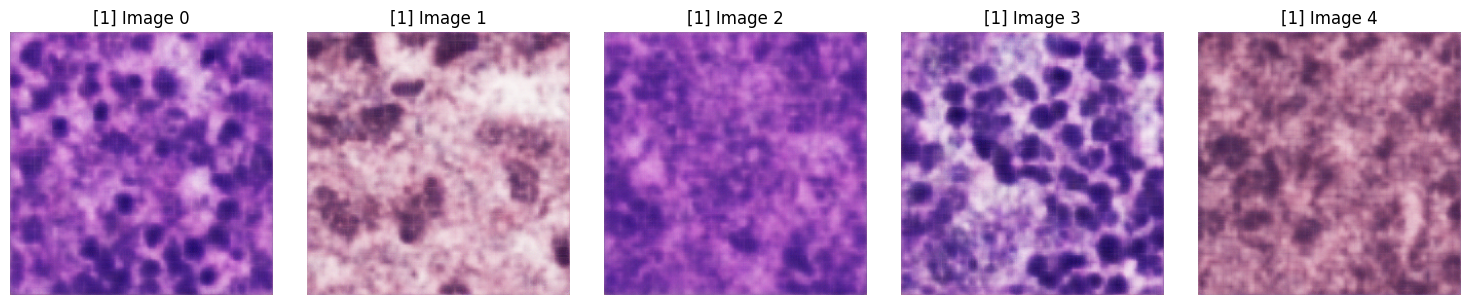

In [17]:
preview_images(syn_loader)

In [20]:
t_data = np.load(f"{DATASET_DIR}/{DATASET_NAME}/{DATASET_NAME}_valid.npz", allow_pickle=True)
t_loader = load_data(t_data)

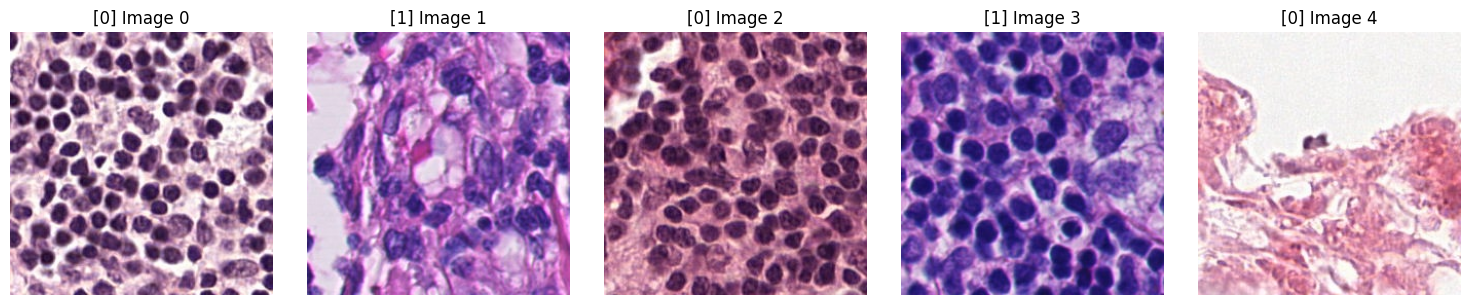

In [45]:
preview_images(t_loader)